AUTHOR: [thanhlv](https://github.com/luvata)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
from keras.layers import *
from keras.models import Model, Sequential
import pandas as pd


## 1. Data Preprocessing

#### 1.1 Vectorization : Data -> Tensor


- Image : Numpy array H x W x C
- Video : N Images => N x H x W x C
- Text :
  - Sentence: one hot
  - One hot word / character -> Word embedding

In [ ]:
import cv2

In [ ]:
!ls

In [ ]:
img = cv2.cvtColor(cv2.imread("feature.png"), cv2.COLOR_BGR2RGB)

In [ ]:
plt.imshow(img)

In [ ]:
V = ["hôm", "nay", "tôi", "đi", "ăn", "học", "chơi", "unk"]

In [ ]:
sentence = "hôm nay ăn chơi"

In [ ]:
def lookup(word: str) -> int:
    try:
        return V.index(word)
    except:
        return V.index("unk")

In [ ]:
V_len = len(V)

In [ ]:
for word in sentence.split(" "):
    one_hot = np.zeros(V_len)
    index = lookup(word)
    one_hot[index] = 1
    print(word, one_hot)

#### 1.2 Value normalization

Why ?

##### Utility functions

In [ ]:
def plot_scatter(X, Y):
    colors = ["#acc2d9", "#56ae57", "#b2996e", "#a8ff04", "#69d84f"]
    for i, _class in enumerate(np.unique(Y)):
        mask = Y == _class
        class_X = X[mask]
        plt.scatter(class_X[:, 0], class_X[:, 1], color=colors[i], alpha=0.8, label=str(_class))
    plt.legend()
    plt.show()

In [ ]:
def plot_history(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.show()

##### Generate data :v

In [ ]:
centers = [[1, 1], [1, 2], [1, 3]]

X, Y = make_blobs(n_samples=1000, centers=centers, cluster_std=0.3, 
                            random_state=0)

In [ ]:
plot_scatter(X, Y)

In [ ]:
### SCALE IT !

In [ ]:
X[:, 0] *= 100

In [ ]:
plot_scatter(X, Y)

In [ ]:
X_raw, Y_raw = X, Y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, Y_raw, 
                                                    test_size=0.2, random_state=42)

In [ ]:
n_dim = X_train.shape[1]
n_classes = len(np.unique(Y))

print("Data dimension: " , n_dim)
print("Number of classes: ", n_classes)


In [ ]:
print(X_train.mean(axis=0))
print(X_train.std(axis=0))

In [ ]:
### Train a simple MLP with keras

In [ ]:
model1 = Sequential([
    Dense(32, input_shape=(2,), activation='sigmoid'),
    Dense(32, activation='sigmoid'),
    Dense(n_classes, activation='softmax')
])

model1.summary()

In [ ]:
model1.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
history = model1.fit(X_train, y_train, epochs=1000, verbose=False)

In [ ]:
plot_history(history)

In [ ]:
model1.predict(X_test).argmax(axis=1)

In [ ]:
accuracy_score(model1.predict(X_test).argmax(axis=1), y_test)

#### Model 2: with normalization

#### MNIST :V
$$ x' = x / 255. $$

#### Rescaling
$$ x' = \frac{x - min(x)}{max(x) - min(x)} $$

##### Standardization:
$$ x' = \frac{x - mean}{std} $$

In [ ]:
mean = X_train.mean(axis=0)
std  = X_train.std(axis=0)

print(mean)
print(std)

In [ ]:
def scaler(X):
    return (X - mean)/std

In [ ]:
### Plot data with scale and without scale
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(X_train[:, 0], ec='k', bins=100)
plt.title("Histogram of non-normalize data")

# with scale:
X_scale = scaler(X_train)
plt.subplot(1, 2, 2)
plt.hist(X_scale[:, 0], ec='k', bins=100)
plt.title("Histogram of normalized data")

In [ ]:
print(X_scale.mean(axis=0))
print(X_scale.std(axis=0))

In [ ]:
plot_scatter(X_scale, y_train)

In [ ]:
model2 = Sequential([
    Lambda(scaler, input_shape=(2,)),  ### <<<<<= Normal distribution Scale
    Dense(32, input_shape=(2,), activation='sigmoid'),
    Dense(32, activation='sigmoid'),
    Dense(n_classes, activation='softmax')
])

model2.summary()

In [ ]:
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
history = model2.fit(X_train, y_train, epochs=400, verbose=False)

In [ ]:
plot_history(history)

In [84]:
accuracy_score(model2.predict(X_test).argmax(axis=1), y_test)

0.935

#### 1.3 Handling missing value

- Ignore :
    - Ignore missing records
    - Ignore missing features 
- Impute:
    - 0 :v
    - Mean
    - Median

## 2. Feature engineering

![feature.png](feature.png)

### Extra 

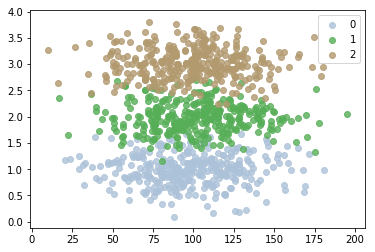

In [80]:
plot_scatter(X, Y)

In [81]:
def dummy_predictor(X):
    y_axis = X[:, 1]
    result = np.zeros_like(y_axis).astype(int)
    # class 0:
    mask_0 =  y_axis <= 1.5
    result[mask_0] = 0
    # class 1:
    mask_1 =  (1.5 < y_axis) & (y_axis <= 2.5)
    result[mask_1] = 1
    # class 2:
    mask_2 = y_axis > 2.5
    result[mask_2] = 2
    return result
    

In [82]:
res = dummy_predictor(X_test)

In [83]:
res

array([1, 2, 0, 2, 1, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2, 2, 0, 2, 1, 1, 1,
       2, 2, 0, 2, 0, 0, 0, 2, 1, 0, 1, 2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 1,
       0, 1, 1, 0, 0, 2, 0, 2, 2, 0, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0, 2, 0,
       2, 1, 0, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 0, 1, 1, 0, 2, 2, 0, 1, 1, 2, 0, 2,
       1, 1, 0, 1, 1, 0, 1, 2, 0, 2, 1, 2, 2, 2, 2, 2, 0, 1, 1, 0, 2, 1,
       2, 1, 0, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 0, 2, 2, 1, 0, 0, 2, 2,
       1, 0, 1, 1, 0, 0, 1, 2, 0, 2, 1, 1, 0, 2, 0, 2, 0, 1, 2, 2, 1, 2,
       2, 0, 0, 1, 1, 0, 2, 2, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 0, 2, 0, 0,
       1, 0])

In [85]:
accuracy_score(res, y_test)

0.93

![meme](https://miro.medium.com/max/722/1*fRctlHDweu2foq6bBmzCgA.png)